# YouTube Machine Learning Model
###### Created by Randhir and Andrew

Model that will take a $90\times120$ thumbnail JPEG and title from YouTube to output a video performance metric.
The metric will be 
$$Score=\log{(View\ Count + 1)}$$
The idea is that the video that attracted more views is a good video. The value is log-scaled as the higher the view count, the less meaningful it becomes. This value will be normalized with the maximum value in the dataset.

#### Imports
This cell contains all the necessary imports of the model.

In [1]:
import string, requests, os, json, random, math
import urllib.request
import urllib.error
from pathlib import Path

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

import numpy as np
import pandas as pd

from PIL import Image

import tensorflow as tf
from tf_keras.backend import clear_session
from tf_keras.callbacks import ModelCheckpoint
from tf_keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Concatenate, Input
from tf_keras.utils import Sequence, plot_model
from tf_keras import Model
from sklearn.model_selection import KFold
from transformers import TFBertModel, BertTokenizer

from dotenv import load_dotenv

# Load .env file with your api key
if not load_dotenv():
	print(".env file not found")

d:\OneDrive\OneDrive - University of Waterloo\School\Courses\4A\MSE 446\Project\YT-ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Constants
This cell contains the constants used by this model

In [ ]:
# File Structure
dirpath = "thumbnail"
modeldir = "models"
datafile = "videos_df.parquet"

# Data Aquisition
filepath = "data.csv"
topic_id = "/m/03hf_rm" # Strategy Games
API_KEY = os.getenv("APIKEY")

# Data Filtering
MULT_CSV = False
filepath_final = "data-filtered.csv"
lang = "en"

# Labeling
MAX_VIEWS = 15.3e9 # Baby Shark Video (Most Viewed Video)
THRESHOLD = 0.4

# Vectorization
vectorizator_model = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(vectorizator_model)
bert_model = TFBertModel.from_pretrained(vectorizator_model)
bert_model.trainable = False

# Text Model Settings
text_input_dim = 20000
embedding_dim = 128
sequence_length = 500

# KFold Settings
n_folds = 5
epochs = 10
batch_size = 30

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

#### Data Aquisition
The YouTube API is used to get video data. This includes a video's thumbnail and metrics.

In [7]:
def query_data(APIKEY : str, topic_filter : str, filedest : str="", query_attempts : int=100, video_count : int=50, lang_filter : str="en", verbose : bool=True) -> pd.DataFrame:
    """
    Data Query Function

    Params
    ======
    APIKEY: Key to the YouTube API
    topic_filter: Topic ID per the YouTube API documentation
    filedest: Location of file to save to; empty string means no file creation or saving; if file exists, will read all data into memory
    query_attempts: Number of times to query the API
    video_count: Number of videos to retrieve from the API per call; maximum value of 50
    lang_filter: language filter for videos; this is not 100% effective

    Returns
    =======
    Dataframe with retrieved data with the following columns:
    ["yt-id", "title", "created", "channel-id", "thumbnail", "thumbnail-w", "thumbnail-h", "view-count", "like-count", "comment-count", "query"]
    """
    # Check if data file already exist
    if filedest != "" and os.path.isfile(filedest):
        df = pd.read_csv(filedest, index_col="yt-id")
    else:
        df = pd.DataFrame([], columns=["yt-id", "title", "created", "channel-id", "thumbnail", "thumbnail-w", "thumbnail-h", "view-count", "like-count", "comment-count", "query"])
        df = df.set_index("yt-id")
        
    # Grab missing data IDs for query
    yt_ids = list(df[df["view-count"].isna()].index)

    # Loop
    yt_reads = 0
    for i in range(query_attempts):
        try:
            # Message
            if verbose:
                print(f"Pulling {video_count} random videos")

            # Generates random query for YT
            r_q = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(3))

            # Calls the API for search results (100 units)
            urlData_query = f"https://www.googleapis.com/youtube/v3/search?key={APIKEY}&maxResults={video_count}&part=snippet&type=video&relevanceLanguage={lang_filter}&topicId={topic_filter}&q={r_q}"
            webURL_query = urllib.request.urlopen(urlData_query)
            raw_vid_data = webURL_query.read()
            results_vids = json.loads(raw_vid_data.decode(webURL_query.info().get_content_charset('utf-8')))

            # Process Video Response
            for video_data in results_vids['items']:
                # Ignore Live and Upcoming Content (no ratings yet)
                if video_data['snippet']['liveBroadcastContent'] != "none":
                    continue

                # Parse data
                try:
                    new_row = pd.DataFrame([{
                        "yt-id": video_data['id']['videoId'],
                        "title": video_data['snippet']['title'],
                        "created": video_data['snippet']['publishedAt'],
                        "channel-id": video_data['snippet']['channelId'],
                        "thumbnail": video_data['snippet']['thumbnails']["default"]["url"],
                        "thumbnail-w": video_data['snippet']['thumbnails']["default"]["width"],
                        "thumbnail-h": video_data['snippet']['thumbnails']["default"]["height"],
                        "query": r_q,
                    },])
                    new_row = new_row.set_index("yt-id")

                    try:
                        # Append
                        df = pd.concat([df, new_row], verify_integrity=True)

                        # Store your ids
                        yt_reads += 1

                        # Prepare id for stats query
                        yt_ids.append(video_data['id']['videoId'])
                    except ValueError:
                        # Duplicate video detected
                        continue
                except KeyError:
                    # Weird Entry
                    continue

            # Update User
            if verbose:
                print(f"API call #{i + 1} successfully")
                
            # Check if any stats calls are needed
            if len(yt_ids) > 0:
                # Message 
                if verbose:
                    print("Pulling statistics for missing data values")

                # Split up batch by 50 due to GET limits
                for batched_ids in np.array_split(yt_ids, math.ceil(len(yt_ids) / 50)):
                    # Generate & call statistic query (1 unit)
                    urlData_stats = f"https://www.googleapis.com/youtube/v3/videos?key={APIKEY}&part=statistics&id={','.join(batched_ids)}"
                    webURL_stats = urllib.request.urlopen(urlData_stats)
                    raw_stats_data = webURL_stats.read()
                    results_stats = json.loads(raw_stats_data.decode(webURL_stats.info().get_content_charset('utf-8')))

                    # Process Stats Response
                    for stats_data in results_stats["items"]:
                        try:
                            # Parse data
                            new_row = pd.DataFrame([{
                                "yt-id": stats_data['id'],
                                "view-count": stats_data['statistics']['viewCount'],
                                "like-count": stats_data['statistics']['likeCount'] if 'likeCount' in stats_data['statistics'] else "",
                                "comment-count": stats_data['statistics']['commentCount'] if 'commentCount' in stats_data['statistics'] else "",
                            },])
                            new_row = new_row.set_index("yt-id")

                            # Update main dataset
                            df.update(new_row)
                        except KeyError:
                            # Weird Entry
                            continue

                # Reset after used
                yt_ids = [] 

                # Message
                if verbose: 
                    print("Finished pulling statistics for current batch")

            # Dumb Data to prevent loss every 5 runs
            if filedest != "" and i % 5 == 0:
                df.to_csv(filedest)

        # ON API failure, quit and save
        except urllib.error.HTTPError:
            if verbose:
                print("Latest API call failed. You are likely out of units. Try again tomorrow.")
            break
        
    # Write to csv
    if filedest != "":
        df.to_csv(filedest)

    # Termination
    if verbose:
        print(f"Was able to pull {yt_reads} rows")

    # Return
    return df

In [ ]:
query_data(API_KEY, topic_id, filepath, 1)

Pulling 50 random videos
API call #1 successfully
Pulling statistics for missing data values


C:\Users\andre\AppData\Local\Temp\ipykernel_12456\532892778.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1692.0 4280.0 7087.0 ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.update(new_row)
C:\Users\andre\AppData\Local\Temp\ipykernel_12456\532892778.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[72.0 147.0 157.0 ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.update(new_row)
C:\Users\andre\AppData\Local\Temp\ipykernel_12456\532892778.py:113: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19.0 18.0 33.0 ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.update(new_row)


Finished pulling statistics for current batch
Was able to pull 46 rows


title  \
yt-id                                                            
ODPTe6U-iEM  Обзор MKA гайд легкий танк Германии | mka брон...   
RhHXknL2GFs                            MKA - ЧТО ЭТО ЗА ТАНК ?   
CYm-YsT3vl4                World of Tanks MKA NEW PREMIUM TANK   
mWiq3uvsy-A  World of Tanks MKA Replay - 10 Kills 1K DMG(Pa...   
556EjhbqSHw                   MKA Yatsumata - Scum PVP Montage   
...                                                        ...   
z205OIIOujs  GBO2: MS-05S Zaku I Commander Type - Outdated ...   
z0mWQ3Yyeww  Vermintide 2 Speedrun - 1m 05s - Cataclysm - G...   
mSp6nCZHY2o  Gundam Battle Operation 2 Request: MS-05 Borja...   
1watBbLtlD8             Watcher Speedrun 4min 05s Narsils Zorn   
A-SfajzOsPY            Cooking Fever-Slots-US-9-16-0402LYH-05S   

                          created                channel-id  \
yt-id                                                         
ODPTe6U-iEM  2022-05-29T10:00:11Z  UCO9nJmvhmpxMWT8BmLatdkg   
RhHXknL2GFs  2018-12-15T06:41:17Z  UCJFDkhBQlwZO9zhsasIMJTw   
CYm-YsT3vl4  2018-12-13T23:15:01Z  UCnwAPSu5aoq3mDt8CARBf4A   
mWiq3uvsy-A  2022-01-26T07:00:46Z  UCpN0uDXIofOi-J0Xx1p-npw   
556EjhbqSHw  2024-05-28T03:01:58Z  UCRs1UCkejoy0-f77UzZ8hVg   
...                           ...                       ...   
z205OIIOujs  2020-04-05T21:38:17Z  UCVE5JLfaBWFl2t7Rld9gvmw   
z0mWQ3Yyeww  2021-04-30T13:05:11Z  UCIZN8fPdQshQml_rBB428xA   
mSp6nCZHY2o  2021-07-16T15:00:34Z  UCQqo4bpmJvIFpj4pG8Sy5Mg   
1watBbLtlD8  2009-11-30T17:45:33Z  UCwumz6bXL5MU1x8qFhSo94Q   
A-SfajzOsPY  2022-04-12T05:50:53Z  UCro2uyw5e67Yy9oxcufmbhQ   

                                                  thumbnail  thumbnail-w  \
yt-id                                                                      
ODPTe6U-iEM  https://i.ytimg.com/vi/ODPTe6U-iEM/default.jpg          120   
RhHXknL2GFs  https://i.ytimg.com/vi/RhHXknL2GFs/default.jpg          120   
CYm-YsT3vl4  https://i.ytimg.com/vi/CYm-YsT3vl4/default.jpg          120   
mWiq3uvsy-A  https://i.ytimg.com/vi/mWiq3uvsy-A/default.jpg          120   
556EjhbqSHw  https://i.ytimg.com/vi/556EjhbqSHw/default.jpg          120   
...                                                     ...          ...   
z205OIIOujs  https://i.ytimg.com/vi/z205OIIOujs/default.jpg          120   
z0mWQ3Yyeww  https://i.ytimg.com/vi/z0mWQ3Yyeww/default.jpg          120   
mSp6nCZHY2o  https://i.ytimg.com/vi/mSp6nCZHY2o/default.jpg          120   
1watBbLtlD8  https://i.ytimg.com/vi/1watBbLtlD8/default.jpg          120   
A-SfajzOsPY  https://i.ytimg.com/vi/A-SfajzOsPY/default.jpg          120   

             thumbnail-h view-count like-count comment-count query  
yt-id                                                               
ODPTe6U-iEM           90     1692.0       72.0          19.0   MKA  
RhHXknL2GFs           90     4280.0      147.0          18.0   MKA  
CYm-YsT3vl4           90     7087.0      157.0          33.0   MKA  
mWiq3uvsy-A           90      385.0       15.0           1.0   MKA  
556EjhbqSHw           90      322.0       22.0          10.0   MKA  
...                  ...        ...        ...           ...   ...  
z205OIIOujs           90         10          0             0   05S  
z0mWQ3Yyeww           90        557         16             2   05S  
mSp6nCZHY2o           90       2599        126            82   05S  
1watBbLtlD8           90       3113          7             4   05S  
A-SfajzOsPY           90        125          0             0   05S  

[53118 rows x 10 columns]

After aquiring the data, the thumbnail images need to be pulled as well.

#### Data Filtering
Some of the pulled data need to be filtered before usage. This includes potential duplicates and non english entries. 

In [ ]:
def filter_data(datas : list[pd.DataFrame], lang_filter : str="en", verbose : bool=True) -> pd.DataFrame:
	"""
	Filters and merges multiple datasets

	Params
	======
	datas: python list of all Dataframes
	lang_filter: language to filter for

	Returns
	=======
	Merged and filtered Dataframe
	"""
	main_df = datas[0]

	for i in range(1, len(datas)):
		main_df = pd.concat([main_df, datas[i]])

	if verbose:
		print(f"{main_df.size} rows in data file")

	# Remove duplicates
	main_df = main_df[~main_df.index.duplicated(keep='first')]
	if verbose:
		print(f"{len(main_df.index)} rows remaining after duplication filter")
		
	# Remove non language
	def _lang_filter(row : pd.Series) -> bool:
		try:
			return detect(row["title"]) == lang_filter
		except LangDetectException:
			return False
		
	main_df = main_df[main_df.apply(_lang_filter, axis=1)]
	if verbose:
		print(f"{len(main_df.index)} rows remaining after translation filter")

	# Save Filtered Data
	return main_df

In [12]:
# Import data for example
demo_df = pd.read_parquet(datafile)
new_df = filter_data([demo_df,])

2082574 rows in data file
2082548 rows remaining after duplication filter
1569880 rows remaining after translation filter


In [13]:
new_df.to_parquet(f"filtered_{datafile}")

#### Thumbnail Requesting
Once the dataset has been filtered, the thumbnails can now be pulled. Images that do not fit the $90\times120$ size or is corrupted will be rejected.

In [15]:
def download_thumbnails(download_dir : str, data : pd.DataFrame, url_col : str="thumbnail", dim_filter : tuple[int, int]=(120, 90), verbose : bool=True) -> pd.DataFrame:
	"""
	Downloads all the image files for each video

	Params
	======
	download_dir: Dirctory to download files to
	data: DataFrame containing all data
	dim_filter: Only accept images of this size

	Returns
	=======
	Dataset with failed entries dropped
	"""
	# Make directory for image if not already
	if not os.path.isdir(download_dir):
		os.mkdir(download_dir)

	# Iterate thru dataframe and download
	def _grab_thumbnail(x : pd.Series):
		# Check if file exist
		filename = f'{dirpath}/{x.name}.jpg'
		if os.path.isfile(filename):
			if verbose:
				print(f"Thumbnail already retrieved for {x.name}")
			return

		# Call file
		with open(filename, 'wb') as handle:
			if verbose:
				print(f"Retrieving thumbnail for {x.name}")
			response = requests.get(x[url_col], stream=True)

			# Fail request
			if not response.ok and verbose:
				print(f"Could not retrieve thumbnail for {x.name}")

			# Success save
			for block in response.iter_content(1024):
				if not block:
					break

				handle.write(block)

		# Open File to Check Corruption
		im = None
		try:
			im = Image.open(filename)

			# Delete File if not right size
			if im.size != dim_filter:
				im.close()
				Path.unlink(filename)
				data.drop(index=x.name)
				if verbose:
					print(f"{x.name} thumbnail is not the correct size. Deleted")
			else:
				im.close()

			im = None
		except:
			# Close bad files
			if im is not None:
				im.close()
				im = None

			# Delete Bad Files
			Path.unlink(filename)
			data.drop(index=x.name)
			if verbose:
				print(f"{x.name} thumbnail is corrupted. Deleted")

	# Apply to all
	data.apply(_grab_thumbnail, axis=1)

	# Return
	return data

In [16]:
downloaded_df = download_thumbnails(dirpath, new_df, "default_url")
downloaded_df.to_parquet(f"downloaded_{datafile}")

Retrieving thumbnail for oLQt8SwaH7w
Retrieving thumbnail for oIbjiihOPcI
Retrieving thumbnail for qdiq0rLvCm4
Retrieving thumbnail for erv6byZ4yf4
Retrieving thumbnail for ishVAymDdCE
Retrieving thumbnail for ATaAUhR8p4s
Retrieving thumbnail for tj_gSswEhYw
Retrieving thumbnail for C4dW_6NqMvA
Retrieving thumbnail for TX8fN-ejN4I
Retrieving thumbnail for Q0wZAtLRs4A
Retrieving thumbnail for UVyQqrVpu1s
Retrieving thumbnail for LVZjQLlKYHQ
Retrieving thumbnail for n6yW8mzu0wo
Retrieving thumbnail for XUQ2GBmYtsY
Retrieving thumbnail for i-CHStmt6oo
Retrieving thumbnail for H2InHT7v0LY
Retrieving thumbnail for IjkZX-woen4
Retrieving thumbnail for Mhf2hR4ogJw
Retrieving thumbnail for x-ilAD2sBaE
Retrieving thumbnail for z_7q3A5Nq9o
Retrieving thumbnail for 4IRhLkReeqc
Retrieving thumbnail for Na6lwGMxG5o
Retrieving thumbnail for yLd-EJ80gLQ
Retrieving thumbnail for yxPgIRjsA9Y
Retrieving thumbnail for n7buO9baG_Y
Retrieving thumbnail for X3ODc12L838
Retrieving thumbnail for 3xz-W0xoAzg
R

videoId                                              title  \
oLQt8SwaH7w  oLQt8SwaH7w                Computer has a built-in chess coach   
oIbjiihOPcI  oIbjiihOPcI       How to give discovered check the right way ✅   
qdiq0rLvCm4  qdiq0rLvCm4                             How to castle in chess   
erv6byZ4yf4  erv6byZ4yf4  Olympiad game: Dragodorf line destroyed! | Che...   
ishVAymDdCE  ishVAymDdCE       How did Frederik Svane recapture the bishop?   
...                  ...                                                ...   
H_nI6dAHI3Q  H_nI6dAHI3Q  Chess Sinhala - 1194 Chess Rating එක තරණය! - E...   
xvVosv-2RBc  xvVosv-2RBc  Chess Sinhala - 2000 Chess Rating Climb Part 3...   
3YkqlIqfPb0  3YkqlIqfPb0  Chess Sinhala - 2000 Chess Rating Climb Part 2...   
OdJXjvgHTdE  OdJXjvgHTdE  Chess Sinhala - 2000 Chess Rating Climb Part 1...   
CgqHASDd7Yc  CgqHASDd7Yc  Chess Sinhala - Magnus Carlsen ආයෙ Play නොකරන ...   

                                                default_url  default_width  \
oLQt8SwaH7w  https://i.ytimg.com/vi/oLQt8SwaH7w/default.jpg          120.0   
oIbjiihOPcI  https://i.ytimg.com/vi/oIbjiihOPcI/default.jpg          120.0   
qdiq0rLvCm4  https://i.ytimg.com/vi/qdiq0rLvCm4/default.jpg          120.0   
erv6byZ4yf4  https://i.ytimg.com/vi/erv6byZ4yf4/default.jpg          120.0   
ishVAymDdCE  https://i.ytimg.com/vi/ishVAymDdCE/default.jpg          120.0   
...                                                     ...            ...   
H_nI6dAHI3Q  https://i.ytimg.com/vi/H_nI6dAHI3Q/default.jpg          120.0   
xvVosv-2RBc  https://i.ytimg.com/vi/xvVosv-2RBc/default.jpg          120.0   
3YkqlIqfPb0  https://i.ytimg.com/vi/3YkqlIqfPb0/default.jpg          120.0   
OdJXjvgHTdE  https://i.ytimg.com/vi/OdJXjvgHTdE/default.jpg          120.0   
CgqHASDd7Yc  https://i.ytimg.com/vi/CgqHASDd7Yc/default.jpg          120.0   

             default_height                                        medium_url  \
oLQt8SwaH7w            90.0  https://i.ytimg.com/vi/oLQt8SwaH7w/mqdefault.jpg   
oIbjiihOPcI            90.0  https://i.ytimg.com/vi/oIbjiihOPcI/mqdefault.jpg   
qdiq0rLvCm4            90.0  https://i.ytimg.com/vi/qdiq0rLvCm4/mqdefault.jpg   
erv6byZ4yf4            90.0  https://i.ytimg.com/vi/erv6byZ4yf4/mqdefault.jpg   
ishVAymDdCE            90.0  https://i.ytimg.com/vi/ishVAymDdCE/mqdefault.jpg   
...                     ...                                               ...   
H_nI6dAHI3Q            90.0  https://i.ytimg.com/vi/H_nI6dAHI3Q/mqdefault.jpg   
xvVosv-2RBc            90.0  https://i.ytimg.com/vi/xvVosv-2RBc/mqdefault.jpg   
3YkqlIqfPb0            90.0  https://i.ytimg.com/vi/3YkqlIqfPb0/mqdefault.jpg   
OdJXjvgHTdE            90.0  https://i.ytimg.com/vi/OdJXjvgHTdE/mqdefault.jpg   
CgqHASDd7Yc            90.0  https://i.ytimg.com/vi/CgqHASDd7Yc/mqdefault.jpg   

             medium_width  medium_height  \
oLQt8SwaH7w         320.0          180.0   
oIbjiihOPcI         320.0          180.0   
qdiq0rLvCm4         320.0          180.0   
erv6byZ4yf4         320.0          180.0   
ishVAymDdCE         320.0          180.0   
...                   ...            ...   
H_nI6dAHI3Q         320.0          180.0   
xvVosv-2RBc         320.0          180.0   
3YkqlIqfPb0         320.0          180.0   
OdJXjvgHTdE         320.0          180.0   
CgqHASDd7Yc         320.0          180.0   

                                                     high_url  high_width  \
oLQt8SwaH7w  https://i.ytimg.com/vi/oLQt8SwaH7w/hqdefault.jpg       480.0   
oIbjiihOPcI  https://i.ytimg.com/vi/oIbjiihOPcI/hqdefault.jpg       480.0   
qdiq0rLvCm4  https://i.ytimg.com/vi/qdiq0rLvCm4/hqdefault.jpg       480.0   
erv6byZ4yf4  https://i.ytimg.com/vi/erv6byZ4yf4/hqdefault.jpg       480.0   
ishVAymDdCE  https://i.ytimg.com/vi/ishVAymDdCE/hqdefault.jpg       480.0   
...                                                       ...         ...   
H_nI6dAHI3Q  https://i.ytimg.com/vi/H_nI6dAHI3Q/hqdefault.jpg       480.0   
xvVosv-2RBc  

#### Data Processing
This process involves text processing and image processing. This will involve text standardization and vectorization. For the image, it needs to be processed and normalized.

##### Import Data

In [ ]:
raw_data = pd.read_parquet(datafile)

# Filter raw data for thumbnail only entries
# thumbnail_ids = pd.Series([f[:-4] for f in os.listdir(dirpath) if os.path.isfile(f"{dirpath}/{f}") and f.endswith(".jpg")], dtype=str)
# raw_data : pd.DataFrame = raw_data.loc[thumbnail_ids]

# raw_data.describe()

videoId                                              title  \
QoxQRSqalZE  QoxQRSqalZE             Schachcomputer im Aldi Nord erhältlich   
oLQt8SwaH7w  oLQt8SwaH7w                Computer has a built-in chess coach   
oIbjiihOPcI  oIbjiihOPcI       How to give discovered check the right way ✅   
qdiq0rLvCm4  qdiq0rLvCm4                             How to castle in chess   
erv6byZ4yf4  erv6byZ4yf4  Olympiad game: Dragodorf line destroyed! | Che...   
...                  ...                                                ...   
H_nI6dAHI3Q  H_nI6dAHI3Q  Chess Sinhala - 1194 Chess Rating එක තරණය! - E...   
xvVosv-2RBc  xvVosv-2RBc  Chess Sinhala - 2000 Chess Rating Climb Part 3...   
3YkqlIqfPb0  3YkqlIqfPb0  Chess Sinhala - 2000 Chess Rating Climb Part 2...   
OdJXjvgHTdE  OdJXjvgHTdE  Chess Sinhala - 2000 Chess Rating Climb Part 1...   
CgqHASDd7Yc  CgqHASDd7Yc  Chess Sinhala - Magnus Carlsen ආයෙ Play නොකරන ...   

                                                default_url  default_width  \
QoxQRSqalZE  https://i.ytimg.com/vi/QoxQRSqalZE/default.jpg          120.0   
oLQt8SwaH7w  https://i.ytimg.com/vi/oLQt8SwaH7w/default.jpg          120.0   
oIbjiihOPcI  https://i.ytimg.com/vi/oIbjiihOPcI/default.jpg          120.0   
qdiq0rLvCm4  https://i.ytimg.com/vi/qdiq0rLvCm4/default.jpg          120.0   
erv6byZ4yf4  https://i.ytimg.com/vi/erv6byZ4yf4/default.jpg          120.0   
...                                                     ...            ...   
H_nI6dAHI3Q  https://i.ytimg.com/vi/H_nI6dAHI3Q/default.jpg          120.0   
xvVosv-2RBc  https://i.ytimg.com/vi/xvVosv-2RBc/default.jpg          120.0   
3YkqlIqfPb0  https://i.ytimg.com/vi/3YkqlIqfPb0/default.jpg          120.0   
OdJXjvgHTdE  https://i.ytimg.com/vi/OdJXjvgHTdE/default.jpg          120.0   
CgqHASDd7Yc  https://i.ytimg.com/vi/CgqHASDd7Yc/default.jpg          120.0   

             default_height                                        medium_url  \
QoxQRSqalZE            90.0  https://i.ytimg.com/vi/QoxQRSqalZE/mqdefault.jpg   
oLQt8SwaH7w            90.0  https://i.ytimg.com/vi/oLQt8SwaH7w/mqdefault.jpg   
oIbjiihOPcI            90.0  https://i.ytimg.com/vi/oIbjiihOPcI/mqdefault.jpg   
qdiq0rLvCm4            90.0  https://i.ytimg.com/vi/qdiq0rLvCm4/mqdefault.jpg   
erv6byZ4yf4            90.0  https://i.ytimg.com/vi/erv6byZ4yf4/mqdefault.jpg   
...                     ...                                               ...   
H_nI6dAHI3Q            90.0  https://i.ytimg.com/vi/H_nI6dAHI3Q/mqdefault.jpg   
xvVosv-2RBc            90.0  https://i.ytimg.com/vi/xvVosv-2RBc/mqdefault.jpg   
3YkqlIqfPb0            90.0  https://i.ytimg.com/vi/3YkqlIqfPb0/mqdefault.jpg   
OdJXjvgHTdE            90.0  https://i.ytimg.com/vi/OdJXjvgHTdE/mqdefault.jpg   
CgqHASDd7Yc            90.0  https://i.ytimg.com/vi/CgqHASDd7Yc/mqdefault.jpg   

             medium_width  medium_height  \
QoxQRSqalZE         320.0          180.0   
oLQt8SwaH7w         320.0          180.0   
oIbjiihOPcI         320.0          180.0   
qdiq0rLvCm4         320.0          180.0   
erv6byZ4yf4         320.0          180.0   
...                   ...            ...   
H_nI6dAHI3Q         320.0          180.0   
xvVosv-2RBc         320.0          180.0   
3YkqlIqfPb0         320.0          180.0   
OdJXjvgHTdE         320.0          180.0   
CgqHASDd7Yc         320.0          180.0   

                                                     high_url  high_width  \
QoxQRSqalZE  https://i.ytimg.com/vi/QoxQRSqalZE/hqdefault.jpg       480.0   
oLQt8SwaH7w  https://i.ytimg.com/vi/oLQt8SwaH7w/hqdefault.jpg       480.0   
oIbjiihOPcI  https://i.ytimg.com/vi/oIbjiihOPcI/hqdefault.jpg       480.0   
qdiq0rLvCm4  https://i.ytimg.com/vi/qdiq0rLvCm4/hqdefault.jpg       480.0   
erv6byZ4yf4  https://i.ytimg.com/vi/erv6byZ4yf4/hqdefault.jpg       480.0   
...                                                       ...         ...   
H_nI6dAHI3Q  https://i.ytimg.com/vi/H_nI6dAHI3Q/hqdefault.jpg       480.0   
xvVosv-2RBc  

In [7]:
raw_data.describe()

default_width  default_height  medium_width  medium_height  high_width  \
count        80099.0         80099.0       80099.0        80099.0     80099.0   
mean           120.0            90.0         320.0          180.0       480.0   
std              0.0             0.0           0.0            0.0         0.0   
min            120.0            90.0         320.0          180.0       480.0   
25%            120.0            90.0         320.0          180.0       480.0   
50%            120.0            90.0         320.0          180.0       480.0   
75%            120.0            90.0         320.0          180.0       480.0   
max            120.0            90.0         320.0          180.0       480.0   

       high_height  standard_width  standard_height  maxres_width  \
count      80099.0         78667.0          78667.0       73400.0   
mean         360.0           640.0            480.0        1280.0   
std            0.0             0.0              0.0           0.0   
min          360.0           640.0            480.0        1280.0   
25%          360.0           640.0            480.0        1280.0   
50%          360.0           640.0            480.0        1280.0   
75%          360.0           640.0            480.0        1280.0   
max          360.0           640.0            480.0        1280.0   

       maxres_height  subscriberCount  totalViewCount  totalVideoCount  
count        73400.0     8.009900e+04    8.009900e+04     80099.000000  
mean           720.0     2.614295e+05    1.620652e+08      6370.135482  
std              0.0     6.843972e+05    4.485963e+08      8685.848625  
min            720.0     1.010000e+02    1.392000e+03        51.000000  
25%            720.0     2.120000e+03    5.598980e+05       604.000000  
50%            720.0     1.690000e+04    6.207470e+06      1793.000000  
75%            720.0     1.200000e+05    8.159261e+07      9720.000000  
max            720.0     5.630000e+06    3.038550e+09     28136.000000

##### Title Tokenization

In [5]:
# Title Processing
input_texts = bert_tokenizer(list(raw_data["title"]), padding=True, truncation=True, max_length=10, return_tensors="tf")

##### Score Generation

In [6]:
# Label Processing
scores = raw_data["view-count"] # Grab View Count
scores = scores.fillna(0.0) # Replace NaN with 0
scores = scores.map(lambda x : np.log10(x + 1)) # Log everything to make it less extreme
scores = scores.div(np.log10(MAX_VIEWS + 1)) # Normalized (+1 to prevent one)

scores.describe()

count    35734.000000
mean         0.251066
std          0.141486
min          0.000000
25%          0.142091
50%          0.237930
75%          0.341665
max          0.819749
Name: view-count, dtype: float64

In [7]:
# Boolean Label
b_scores = scores.map(lambda x : int(x >= THRESHOLD))

b_scores.describe()

count    35734.000000
mean         0.158281
std          0.365009
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: view-count, dtype: float64

#### Models
Commonly, the Sequential API is used to train a model. However, due to the need for more than one input, the Functional API must be employed.

##### Image-Only Model

Model: "img_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_inputs (InputLayer)   [(None, 90, 120, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 90, 120, 32)       2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 30, 128)       73

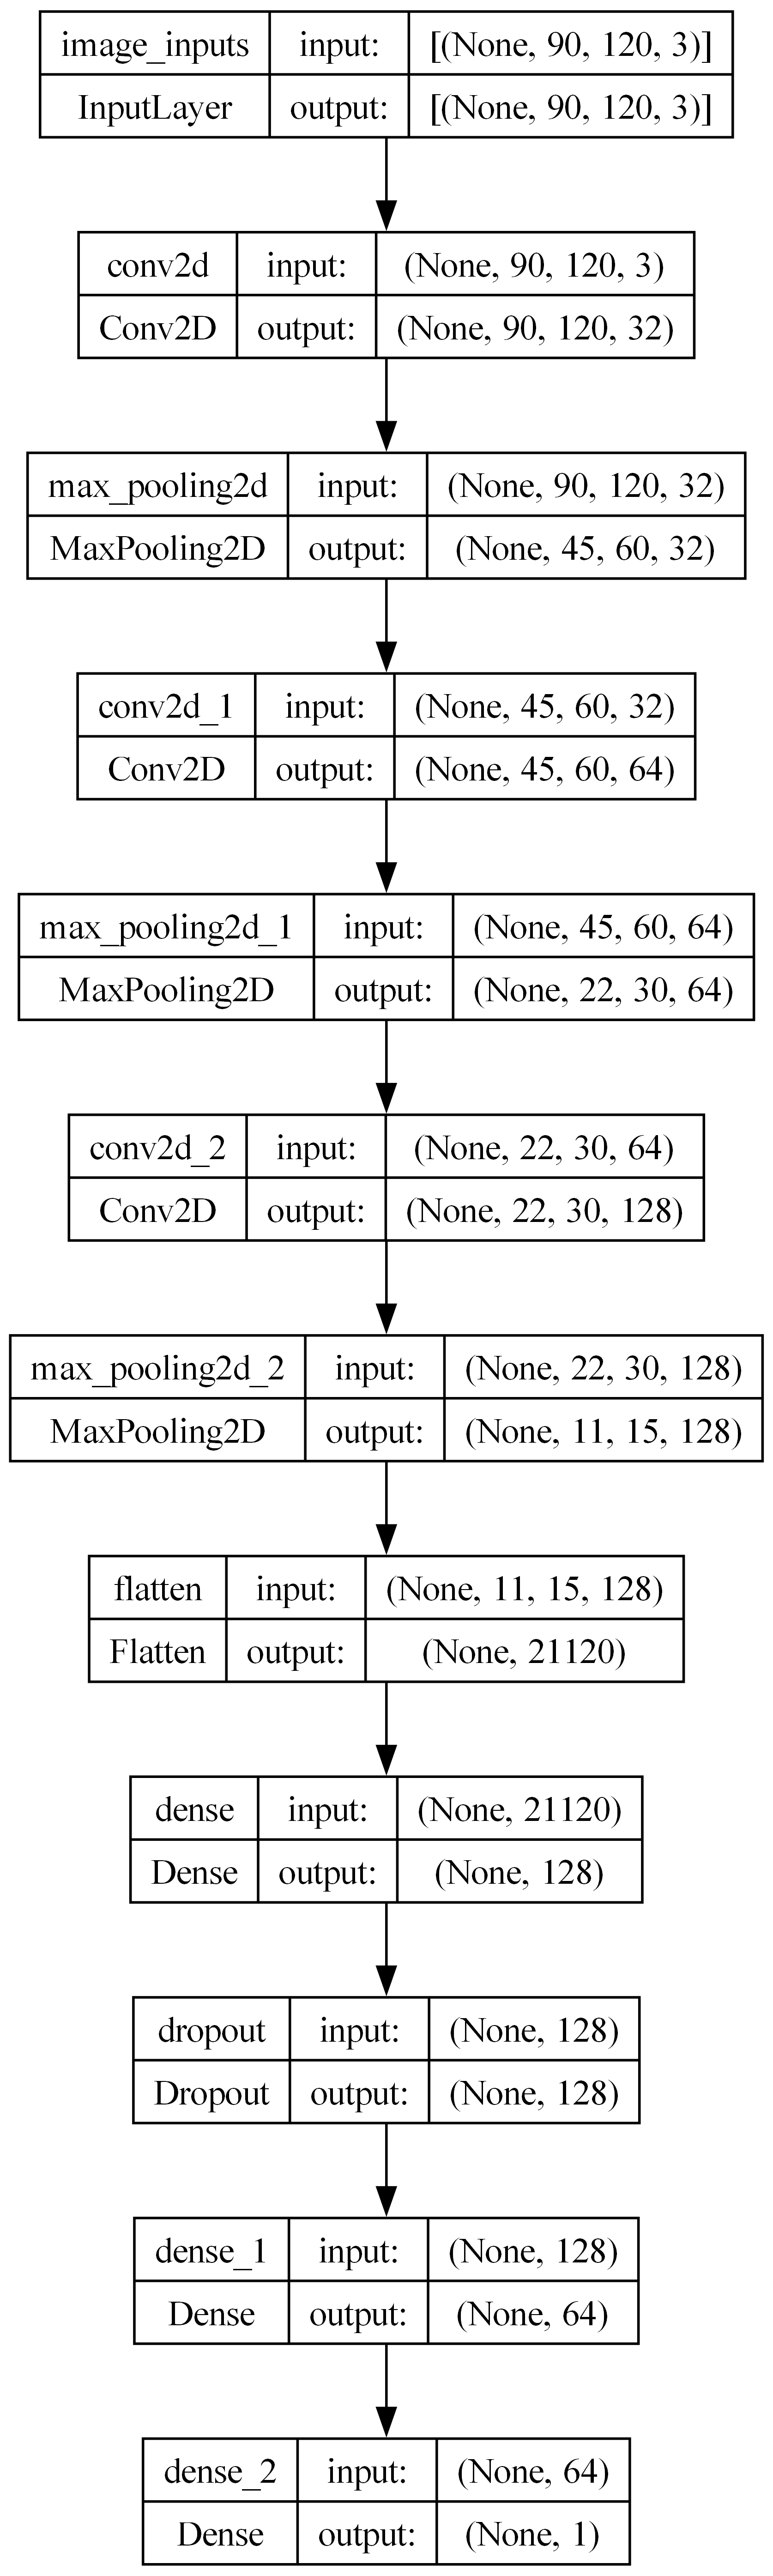

In [28]:
# Image Portion
img_input = Input((90, 120, 3), name="image_inputs")
x = Conv2D(32, 5, activation='relu', padding='same')(img_input)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x_out = Dropout(0.5)(x)
x_out = Dense(64, activation='relu')(x_out)
img_output = Dense(1, activation='sigmoid')(x_out)

img_model = Model(inputs=img_input, outputs=img_output, name="img_model")

img_model.summary()
plot_model(img_model, to_file='img_model.png', show_shapes=True, dpi=400)

##### Text-Only Model

Model: "text_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_inputs (InputLayer)    [(None, 10)]                 0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 10)]                 0         []                            
 r)                                                                                               
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['text_inputs[0][0]',         
 )                           ngAndCrossAttentions(last_   40         'attention_masks[0][0]']     
                             hidden_state=(None, 10, 76                                  

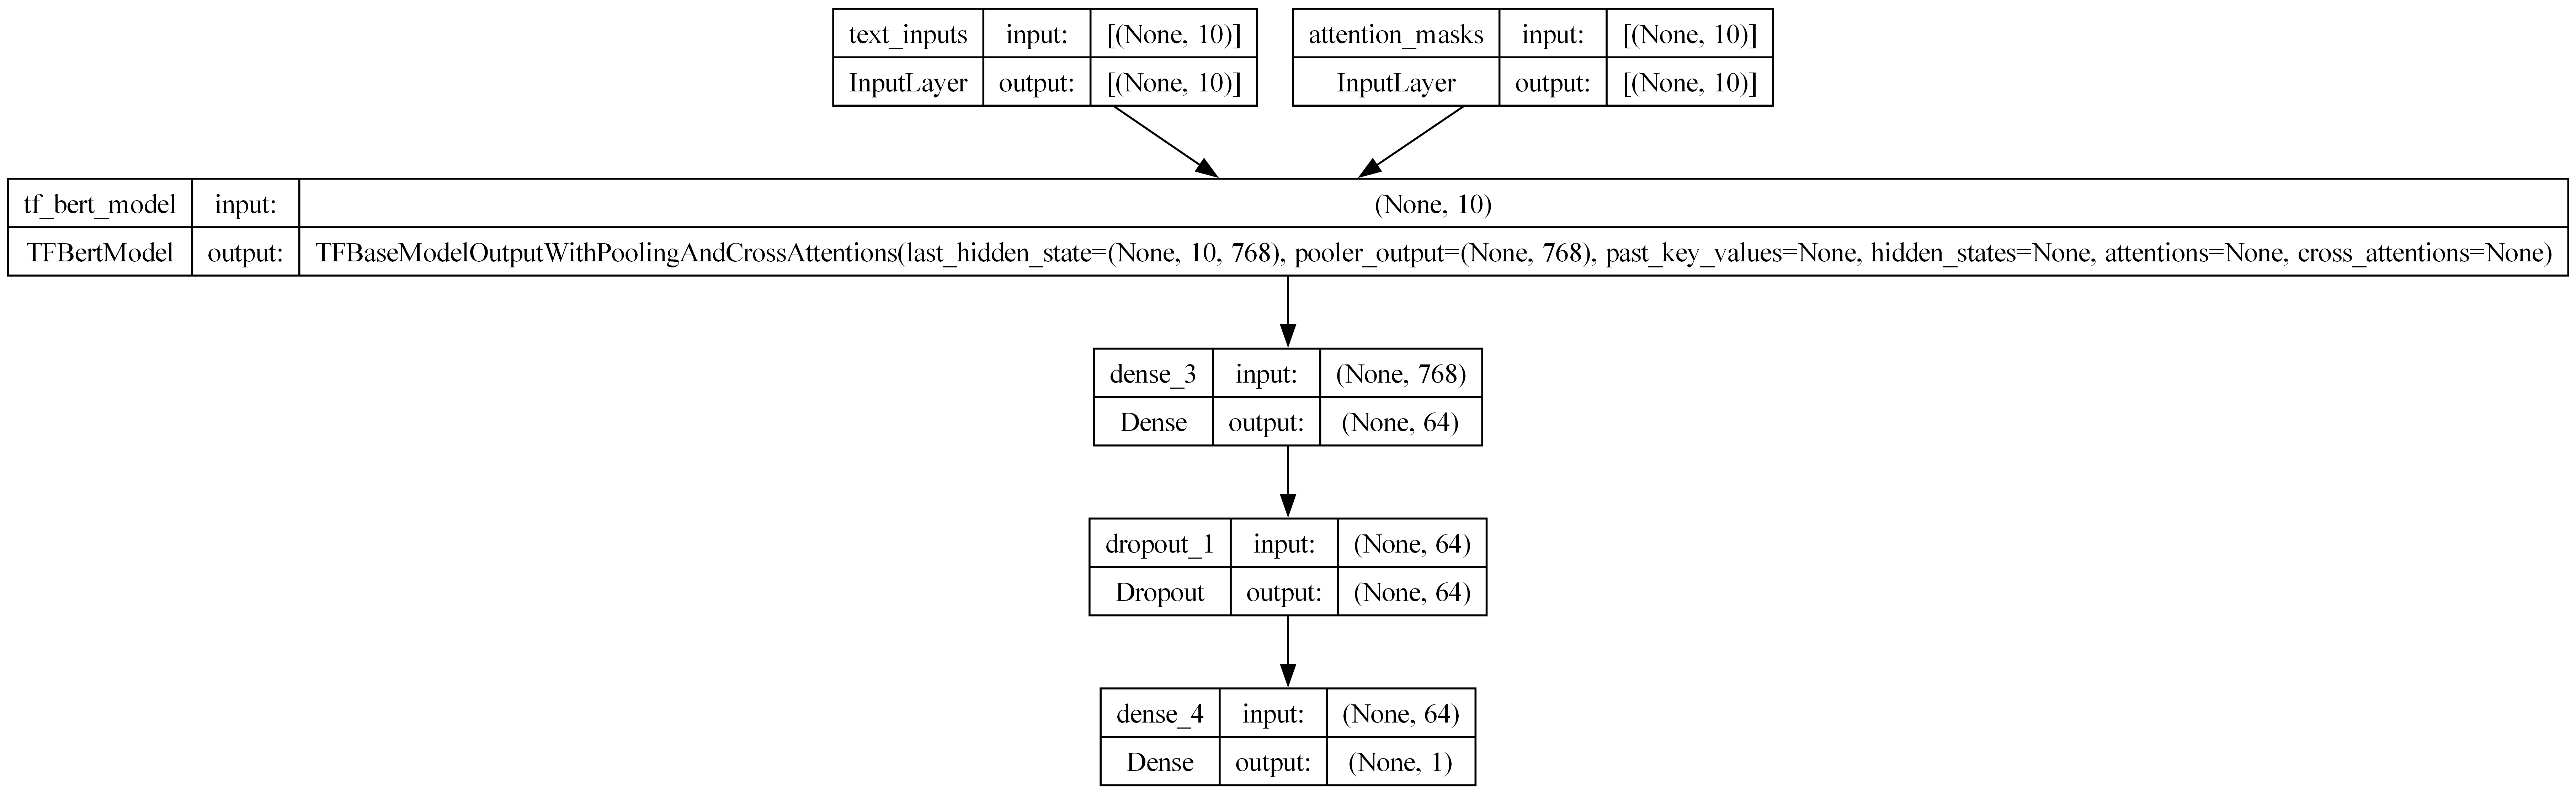

In [29]:
# Text Portion
text_input = Input(shape=(10,), dtype=tf.int32, name="text_inputs")
attention_mask = Input(shape=(10,), dtype=tf.int32, name="attention_masks")

transformer_output = bert_model(text_input, attention_mask=attention_mask)

# y = transformer_output.last_hidden_state[:, 0, :]
y = transformer_output.pooler_output

y = Dense(64, activation='relu')(y)
y_out = Dropout(0.5)(y)
text_output = Dense(1, activation='sigmoid')(y_out)

text_model = Model(inputs=[text_input, attention_mask], outputs=text_output, name="text_model")

text_model.summary()
plot_model(text_model, to_file='text_model.png', show_shapes=True, dpi=400)

##### United Model

In [30]:
# United Model
z = Concatenate()([x, y])
z = Dropout(0.5)(z)
z = Dense(32, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)

united_model = Model(inputs=[img_input, text_input, attention_mask], outputs=z, name="united_model")

united_model.summary()
plot_model(united_model, to_file='united_model.png', show_shapes=True, dpi=400)

Model: "united_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_inputs (InputLayer)   [(None, 90, 120, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 90, 120, 32)          2432      ['image_inputs[0][0]']        
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 45, 60, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 45, 60, 64)           18496     ['max_pooling2d[0][

#### Generators
To lower memory usage, the dataset needs to be batched. This is done through the use of generators.

##### Thumbnail Data Generator
This generator is for the image-only model

In [14]:
class ThumbnailDataGenerator(Sequence):

	def __init__(self, 
			  filedir : str, 
			  list_IDs : pd.Series, 
			  labels : pd.Series, 
			  rescale : float=255.0, 
			  filetype : str="jpg", 
			  batch_size : int=32, 
			  dim : tuple[int, int]=(90, 120), 
			  shuffle=True
		):
		'''
		Data Generator Initialization Function 
		'''
		# File Location & Info
		self.filedir = filedir
		self.filetype = filetype

		# Image Settings
		self.dim = dim
		self.rescale = rescale

		# Batching
		self.batch_size = batch_size
		self.shuffle = shuffle

		# Datasets
		self.labels = labels
		self.list_IDs = list_IDs

		self.on_epoch_end()

	def on_epoch_end(self):
		'''
		Updates indexes after each epoch
		'''
		self.indexes = np.arange(len(self.list_IDs))

		# Randomize if Shuffle
		if self.shuffle:
			np.random.shuffle(self.indexes)

	def __data_generation(self, list_IDs_temp):
		'''
		Generates data containing batch_size samples
		'''
		# Initialization
		X = np.empty((self.batch_size, *self.dim, 3))
		y = np.empty((self.batch_size), dtype=float)

		# Generate data
		for i, ID in enumerate(list_IDs_temp):
			# Store sample
			X[i,] = Image.open(f'{self.filedir}/{ID}.{self.filetype}')

			# Store class
			y[i] = self.labels[ID]

		# Rescale
		X /= self.rescale

		return X, y
	
	def __len__(self):
		'''
		Denotes the number of batches per epoch
		'''
		return int(np.floor(len(self.list_IDs) / self.batch_size))
	
	def __getitem__(self, index):
		'''
		Generate one batch of data
		'''
		# Generate indexes of the batch
		indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

		# Find list of IDs
		list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

		# Generate data
		return self.__data_generation(list_IDs_temp)

##### Thumbnail and Title Data Generator
The following generator is meant to handle both images and text inputs.

In [21]:
class ThumbnailTitleDataGenerator(Sequence):

	def __init__(self, 
			  filedir : str, 
			  list_IDs : pd.Series, 
			  texts : pd.Series, 
			  labels : pd.Series, 
			  rescale : float=255.0, 
			  filetype : str="jpg", 
			  batch_size : int=32, 
			  img_dim : tuple[int, int]=(90, 120), 
			  text_dim : int=10, 
			  tokenizer : BertTokenizer=None,
			  img_input_name : str="image_inputs",
			  text_input_name : str="text_inputs",
			  attention_input_name : str="attention_masks",
			  shuffle=True
		):
		'''
		Data Generator Initialization Function 
		'''
		# File Location & Info
		self.filedir = filedir
		self.filetype = filetype

		# Dimensions
		self.img_dim = img_dim
		self.text_dim = text_dim
		self.rescale = rescale

		# Batching
		self.batch_size = batch_size
		self.shuffle = shuffle

		# Datasets
		self.labels = labels
		self.list_IDs = list_IDs
		self.texts = texts
		self.tokenizer = tokenizer

		# Input Names
		self.img_input_name = img_input_name
		self.text_input_name = text_input_name
		self.attention_input_name = attention_input_name

		self.on_epoch_end()

	def on_epoch_end(self):
		'''
		Updates indexes after each epoch
		'''
		self.indexes = np.arange(len(self.list_IDs))

		# Randomize if Shuffle
		if self.shuffle:
			np.random.shuffle(self.indexes)

	def __data_generation(self, list_IDs_temp : list[str]):
		'''
		Generates data containing batch_size samples
		'''
		# Initialization
		X_IMG = np.empty((self.batch_size, *self.img_dim, 3))
		X_TEXT = np.empty((self.batch_size, self.text_dim))
		X_ATTENTION = np.empty((self.batch_size, self.text_dim))
		y = np.empty((self.batch_size), dtype=float)

		# Generate data
		temp_titles : list[str] = [None] * self.batch_size
		for i, ID in enumerate(list_IDs_temp):
			# Store sample
			X_IMG[i,] = Image.open(f'{self.filedir}/{ID}.{self.filetype}')

			# Process title
			temp_titles[i] = self.texts[ID]

			# Store class
			y[i] = self.labels[ID]

		# Rescale
		X_IMG /= self.rescale

		# Encode Text
		encoded_text = self.tokenizer(temp_titles, padding=True, truncation=True, max_length=self.text_dim)
		X_TEXT[:,:] = encoded_text["input_ids"]
		X_ATTENTION[:,:] = encoded_text["attention_mask"]

		# Unify Inputs
		X = {
			self.img_input_name: X_IMG,
			self.text_input_name: X_TEXT,
			self.attention_input_name: X_ATTENTION
		}

		return X, y
	
	def __len__(self):
		'''
		Denotes the number of batches per epoch
		'''
		return int(np.floor(len(self.list_IDs) / self.batch_size))
	
	def __getitem__(self, index):
		'''
		Generate one batch of data
		'''
		# Generate indexes of the batch
		indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

		# Find list of IDs
		list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

		# Generate data
		return self.__data_generation(list_IDs_temp)

#### Training
Using k-fold cross validation, we can judge the accuarcy of this models. The models will undergo a k-fold cross validation.

##### Image-Only Training

In [26]:
# Image Model
kf = KFold(n_folds)

img_validation_accuracy = []
img_validation_loss = []

fold_var = 1
for train, val in kf.split(thumbnail_ids, b_scores):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	img_model = Model(inputs=img_input, outputs=img_output, name="img_model")
	img_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/img-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

	# Generator
	tbdg_train = ThumbnailDataGenerator(dirpath, thumbnail_ids.iloc[train], b_scores.iloc[train], batch_size=batch_size)
	tbdg_validate = ThumbnailDataGenerator(dirpath, thumbnail_ids.iloc[val], b_scores.iloc[val], batch_size=batch_size)

	# Fit
	history = img_model.fit(x=tbdg_train, validation_data=tbdg_validate, callbacks=[checkpoint], epochs=epochs)

	# Grab Results
	img_model.load_weights(f"{modeldir}/img-model_{fold_var}.h5")
	
	results = img_model.evaluate(x=tbdg_validate)
	results = dict(zip(img_model.metrics_names, results))
	
	img_validation_accuracy.append(results['accuracy'])
	img_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/5
952/952 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.8347 - precision: 0.1429 - recall: 0.0021
Epoch 1: val_accuracy improved from -inf to 0.86275, saving model to models\img-model_1.h5
952/952 [==============================] - 99s 102ms/step - loss: 0.4204 - accuracy: 0.8347 - precision: 0.1429 - recall: 0.0021 - val_loss: 0.3563 - val_accuracy: 0.8627 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
  1/952 [..............................] - ETA: 2:01 - loss: 0.3275 - accuracy: 0.9000 - precision: 0.0000e+00 - recall: 0.0000e+00

d:\OneDrive\OneDrive - University of Waterloo\School\Courses\4A\MSE 446\Project\YT-ML\.venv\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


952/952 [==============================] - ETA: 0s - loss: 0.3987 - accuracy: 0.8365 - precision: 0.5000 - recall: 6.4254e-04
Epoch 2: val_accuracy did not improve from 0.86275
952/952 [==============================] - 96s 101ms/step - loss: 0.3987 - accuracy: 0.8365 - precision: 0.5000 - recall: 6.4254e-04 - val_loss: 0.3602 - val_accuracy: 0.8627 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
952/952 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8360 - precision: 0.3571 - recall: 0.0043
Epoch 3: val_accuracy did not improve from 0.86275
952/952 [==============================] - 95s 100ms/step - loss: 0.3912 - accuracy: 0.8360 - precision: 0.3571 - recall: 0.0043 - val_loss: 0.3501 - val_accuracy: 0.8625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
952/952 [==============================] - ETA: 0s - loss: 0.3882 - accuracy: 0.8355 - precision: 0.4364 - recall: 0.0206
Epoch 4: val_accuracy did not improve from 0.86275
952/9

##### Text-Only Training

In [27]:
# Text Model
kf = KFold(n_folds)

text_validation_accuracy = []
text_validation_loss = []

fold_var = 1
for train, val in kf.split(input_texts["input_ids"], b_scores):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	text_model = Model(inputs=[text_input, attention_mask], outputs=text_output, name="text_model")
	text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/text-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

	# Train / Validation
	trainset = {
		"text_inputs": tf.gather(input_texts["input_ids"], indices=train), 
		"attention_masks": tf.gather(input_texts["attention_mask"], indices=train)
	}
	testset = {
		"text_inputs": tf.gather(input_texts["input_ids"], indices=val), 
		"attention_masks": tf.gather(input_texts["attention_mask"], indices=val)
	}

	# Fit
	history = text_model.fit(x=trainset, y=b_scores.iloc[train], validation_data=(testset, b_scores.iloc[val]), callbacks=[checkpoint], epochs=epochs)

	# Grab Results
	text_model.load_weights(f"{modeldir}/text-model_{fold_var}.h5")
	
	results = text_model.evaluate(x=testset, y=b_scores.iloc[val])
	results = dict(zip(text_model.metrics_names, results))
	
	text_validation_accuracy.append(results['accuracy'])
	text_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/5
894/894 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.8356
Epoch 1: val_accuracy improved from -inf to 0.86260, saving model to models\text-model_1.h5
894/894 [==============================] - 232s 248ms/step - loss: 0.4638 - accuracy: 0.8356 - val_loss: 0.3875 - val_accuracy: 0.8626
Epoch 2/5
894/894 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.8364
Epoch 2: val_accuracy did not improve from 0.86260
894/894 [==============================] - 225s 252ms/step - loss: 0.4446 - accuracy: 0.8364 - val_loss: 0.3817 - val_accuracy: 0.8626
Epoch 3/5
894/894 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.8364
Epoch 3: val_accuracy did not improve from 0.86260
894/894 [==============================] - 218s 244ms/step - loss: 0.4399 - accuracy: 0.8364 - val_loss: 0.3864 - val_accuracy: 0.8625
Epoch 4/5
894/894 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8364
Ep

##### United Training

In [22]:
# United Model
kf = KFold(n_folds)

united_validation_accuracy = []
united_validation_loss = []

fold_var = 1
for train, val in kf.split(thumbnail_ids, b_scores):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	united_model = Model(inputs=[img_input, text_input, attention_mask], outputs=z, name="united_model")
	united_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/complete-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

	# Generator
	tbtdg_train = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids.iloc[train], raw_data["title"].iloc[train], b_scores.iloc[train], batch_size=batch_size, tokenizer=bert_tokenizer)
	tbtdg_validate = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids.iloc[val], raw_data["title"].iloc[val], b_scores.iloc[val], batch_size=batch_size, tokenizer=bert_tokenizer)

	# Fit
	history = united_model.fit(x=tbtdg_train, validation_data=tbtdg_validate, callbacks=[checkpoint], epochs=epochs)

	# Grab Results
	united_model.load_weights(f"{modeldir}/complete-model_{fold_var}.h5")
	
	results = united_model.evaluate(x=tbtdg_validate)
	results = dict(zip(united_model.metrics_names, results))
	
	united_validation_accuracy.append(results['accuracy'])
	united_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/5


952/952 [==============================] - ETA: 0s - loss: 0.4182 - accuracy: 0.8350 - precision: 0.2162 - recall: 0.0034
Epoch 1: val_accuracy improved from -inf to 0.86261, saving model to models\complete-model_1.h5


d:\OneDrive\OneDrive - University of Waterloo\School\Courses\4A\MSE 446\Project\YT-ML\.venv\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


952/952 [==============================] - 829s 856ms/step - loss: 0.4182 - accuracy: 0.8350 - precision: 0.2162 - recall: 0.0034 - val_loss: 0.3420 - val_accuracy: 0.8626 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
952/952 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.8365 - precision: 0.5116 - recall: 0.0141
Epoch 2: val_accuracy improved from 0.86261 to 0.86317, saving model to models\complete-model_1.h5
952/952 [==============================] - 300s 315ms/step - loss: 0.3973 - accuracy: 0.8365 - precision: 0.5116 - recall: 0.0141 - val_loss: 0.3446 - val_accuracy: 0.8632 - val_precision: 0.5101 - val_recall: 0.1030
Epoch 3/5
952/952 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8362 - precision: 0.4889 - recall: 0.0330
Epoch 3: val_accuracy did not improve from 0.86317
952/952 [==============================] - 286s 300ms/step - loss: 0.3900 - accuracy: 0.8362 - precision: 0.4889 - recall: 0.0330 - val_loss: 0.

##### Final Training
Once all the models have been trained and analysised with k-fold cross validation, the final model will be trained with all the data. It will then be tested with new data from the YouTube API.

In [ ]:
# Clear Keras
clear_session()

# Make image model for testing
united_model = Model(inputs=[img_input, text_input, attention_mask], outputs=z, name="final_united_model")
united_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Callback Saving
checkpoint = ModelCheckpoint(f"{modeldir}/final-complete-model.h5", monitor='accuracy', verbose=1, save_best_only=True, mode='max')

# Generator
tbtdg_train = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids, raw_data["title"], b_scores, batch_size=batch_size, tokenizer=bert_tokenizer)

# Fit
history = united_model.fit(x=tbtdg_train, callbacks=[checkpoint], epochs=epochs)

Epoch 1/10
1191/1191 [==============================] - 332s 269ms/step - loss: 0.4065 - accuracy: 0.8403 - precision: 0.2869 - recall: 0.0062
Epoch 2/10
1191/1191 [==============================] - 319s 268ms/step - loss: 0.3870 - accuracy: 0.8417 - precision: 0.4894 - recall: 0.0081
Epoch 3/10
1191/1191 [==============================] - 318s 267ms/step - loss: 0.3795 - accuracy: 0.8423 - precision: 0.5309 - recall: 0.0288
Epoch 4/10
1191/1191 [==============================] - 314s 264ms/step - loss: 0.3755 - accuracy: 0.8426 - precision: 0.5312 - recall: 0.0497
Epoch 5/10
1191/1191 [==============================] - 316s 265ms/step - loss: 0.3680 - accuracy: 0.8444 - precision: 0.5508 - recall: 0.0939
Epoch 6/10
1191/1191 [==============================] - 318s 267ms/step - loss: 0.3618 - accuracy: 0.8482 - precision: 0.5875 - recall: 0.1377
Epoch 7/10
1191/1191 [==============================] - 321s 269ms/step - loss: 0.3502 - accuracy: 0.8535 - precision: 0.6246 - recall: 0.1857

#### Testing with New Data
Only a final model has been trained, it must be tested with new data. This can be collected from the YouTube API.